<a href="https://colab.research.google.com/github/Minatozaki0911/CapstoneProject202/blob/main/Do_an_HK202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install keras

In [2]:
import os
import cv2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style

from tensorflow import keras
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import pandas as pd

In [3]:
!unzip '/content/drive/MyDrive/Colab Notebooks/DO_AN_HK202/dataHandLang.zip' -d '/content/drive/mMyDrive/Colab Notebooks/DO_AN_HK202/train'

Archive:  /content/drive/MyDrive/Colab Notebooks/DO_AN_HK202/dataHandLang.zip
checkdir:  cannot create extraction directory: /content/drive/mMyDrive/Colab Notebooks/DO_AN_HK202/train
           No such file or directory


In [4]:
gesture_names = {0: 'E',
                 1: 'L',
                 2: 'F',
                 3: 'V',
                 4: 'B'}

gestures = {'L_': 'L',
           'fi': 'E',
           'ok': 'F',
           'pe': 'V',
           'pa': 'B'
            }

gestures_map = {'E': 0,
                'L': 1,
                'F': 2,
                'V': 3,
                'B': 4
                }
dimension = 224            

In [5]:
image_path = '/content/drive/MyDrive/Colab Notebooks/DO_AN_HK202/train'
model_path = '/content/drive/MyDrive/Colab Notebooks/DO_AN_HK202/'

In [6]:
def process_image(path):
    img = Image.open(path)
    img = img.resize((dimension, dimension))
    img = np.array(img)
    return img

In [7]:
def process_data(X_data, y_data):
    X_data = np.array(X_data, dtype = 'float32')
    X_data = np.stack((X_data,)*3, axis=-1)
    X_data /= 255
    y_data = np.array(y_data)
    y_data = to_categorical(y_data)
    return X_data, y_data

In [8]:
def walk_file_tree(image_path):
    X_data = []
    y_data = []
    for directory, subdirectories, files in os.walk(image_path):
        for file in files:
            if not file.startswith('.'):
                path = os.path.join(directory, file)
                gesture_name = gestures[file[0:2]]
                print(gesture_name)
                print(gestures_map[gesture_name])
                y_data.append(gestures_map[gesture_name])
                X_data.append(process_image(path))

            else:
                continue

    X_data, y_data = process_data(X_data, y_data)
    return X_data, y_data

In [ ]:
X_data, y_data = walk_file_tree(image_path)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,
                                                    test_size = 0.2, 
                                                    random_state=12, 
                                                    stratify=y_data)

In [20]:
model_checkpoint = ModelCheckpoint(filepath=model_path, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_acc',
                               min_delta=0,
                               patience=10,
                               verbose=1,
                               mode='auto',
                               restore_best_weights=True)

In [21]:
model1 = VGG16(weights='imagenet', include_top=False, input_shape=(dimension, dimension, 3))
optimizer1 = optimizers.Adam()
base_model = model1

In [23]:
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)

In [24]:
model = Model(inputs=base_model.input, outputs=predictions)

In [25]:
for layer in base_model.layers:
    layer.trainable = False

In [26]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['acc'])

In [28]:
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), verbose=1,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/30
69/69 [==============================] - 12s 171ms/step - loss: 0.0756 - acc: 0.9750 - val_loss: 0.0409 - val_acc: 0.9855
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/DO_AN_HK202/assets
Epoch 2/30
69/69 [==============================] - 12s 171ms/step - loss: 0.0338 - acc: 0.9900 - val_loss: 0.0902 - val_acc: 0.9691
Epoch 3/30
69/69 [==============================] - 12s 172ms/step - loss: 0.0433 - acc: 0.9864 - val_loss: 0.0483 - val_acc: 0.9800
Epoch 4/30
69/69 [==============================] - 12s 173ms/step - loss: 0.0087 - acc: 0.9964 - val_loss: 0.1216 - val_acc: 0.9764
Epoch 5/30
69/69 [==============================] - 12s 174ms/step - loss: 0.0555 - acc: 0.9850 - val_loss: 0.0478 - val_acc: 0.9818
Epoch 6/30
69/69 [==============================] - 12s 174ms/step - loss: 0.0058 - acc: 0.9991 - val_loss: 0.0684 - val_acc: 0.9855
Epoch 7/30
69/69 [==============================] - 12s 175ms/step - loss: 0.0221 - acc: 0.9932 - val_loss: 0

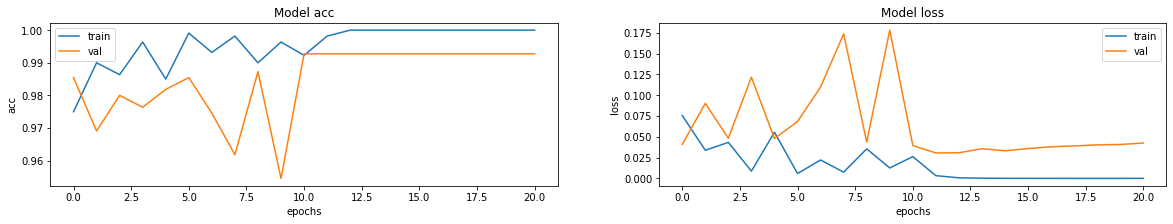

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [30]:
os.chdir('/content/drive/MyDrive/Colab Notebooks')
model.save("Do_an_HK202")         #Model folder contain .pb file
model.save("ThaiBaoKhang.h5")            #HDF5 format for custom use

INFO:tensorflow:Assets written to: Do_an_HK202/assets
